## Buňka 1: Úvod a příprava prostředí

In [1]:
# ===================================================================
# BUŇKA 1: ÚVOD A PŘÍPRAVA PROSTŘEDÍ
# CELL 1: INTRODUCTION AND ENVIRONMENT SETUP
# ===================================================================
# Tento sešit slouží jako interaktivní a replikovatelný "živý důkaz"
# pro Teorii LiliQuant. Jeho cílem je experimentálně ověřit klíčovou
# hypotézu teorie: detekovatelnost narušení "latentní stability" v komplexních signálech.
#
# This notebook serves as an interactive and reproducible "live proof"
# for the LiliQuant Theory. Its purpose is to experimentally verify the theory's key
# hypothesis: the detectability of "latent stability" disruptions in complex signals.


# 1) Připojení Google Drive / Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

# 2) Vytvoření pracovní složky / Create working directory
working_directory = '/content/drive/MyDrive/LiliQ_Final_Proof'
os.makedirs(working_directory, exist_ok=True)
os.chdir(working_directory)
print(f"Pracovní adresář / Working directory: {os.getcwd()}")

# 3) Instalace a import potřebných knihoven / Install and import necessary libraries
print("\nInstaluji potřebné knihovny... / Installing necessary libraries...")
!pip install numpy scipy matplotlib pandas tqdm mne seaborn tensorflow -q
print("Knihovny jsou připraveny. / Libraries are ready.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
from tqdm.notebook import tqdm
import mne
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import random
import time

# 4) Nastavení stylu grafů a seedu pro replikovatelnost / Set plot style and seed for reproducibility
sns.set(style="whitegrid")
%matplotlib inline
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("\nProstředí je připraveno a seed pro replikovatelnost byl nastaven.")
print("Environment is ready and the seed for reproducibility has been set.")

Mounted at /content/drive
Pracovní adresář / Working directory: /content/drive/MyDrive/LiliQ_Final_Proof

Instaluji potřebné knihovny... / Installing necessary libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 86.3 MB/s eta 0:00:00
Knihovny jsou připraveny. / Libraries are ready.

Prostředí je připraveno a seed pro replikovatelnost byl nastaven.
Environment is ready and the seed for reproducibility has been set.


## Buňka 2: Načtení Dat a Generování Signálu

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Načteno 166800 vzorků EEG signálu, sfreq = 600.61 Hz
Loaded 166800 EEG signal samples, sfreq = 600.61 Hz
Vygenerován teoretický signál (šum). / Theoretical signal (noise) generated.


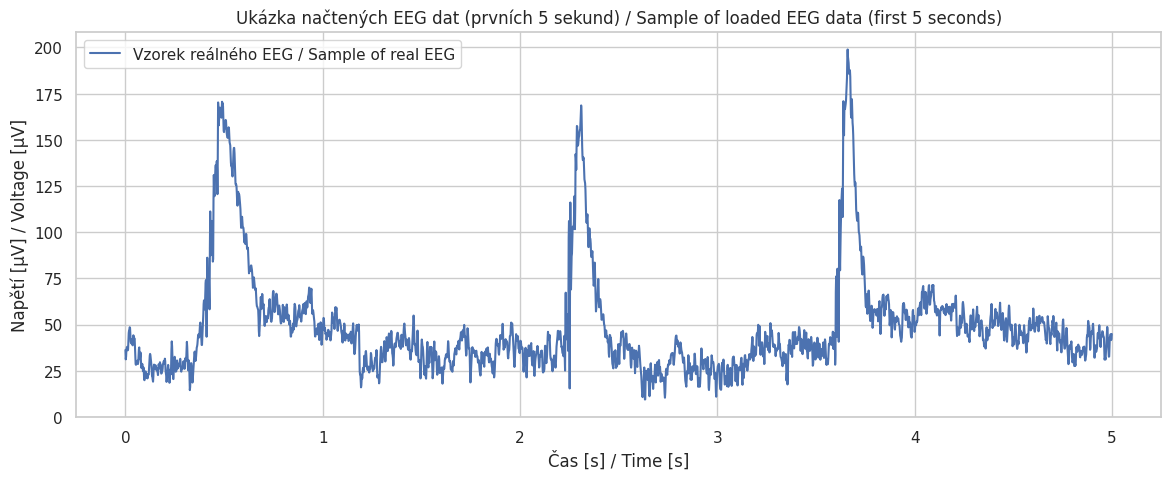


Data jsou připravena pro experimenty v Části B. / Data is ready for experiments in Part B.


In [2]:
# ===================================================================
# BUŇKA 2: NAČTENÍ DAT A GENEROVÁNÍ SIGNÁLU
# CELL 2: DATA LOADING AND SIGNAL GENERATION
# ===================================================================
# Tato buňka načte reálná EEG data a vygeneruje teoretický signál.
# Musí být spuštěna před spuštěním experimentů v Části B.
#
# This cell loads real EEG data and generates the theoretical signal.
# It must be run before executing the experiments in Part B.

# 1) Načtení reálných EEG dat / Load real EEG data
sample_folder = mne.datasets.sample.data_path(verbose=False)
raw = mne.io.read_raw_fif(
    os.path.join(sample_folder, 'MEG', 'sample', 'sample_audvis_raw.fif'),
    preload=True, verbose=False
)
raw.pick_types(eeg=True, meg=False, stim=False, eog=False)
raw.pick_channels(['EEG 003'])
eeg_data, times = raw.get_data(return_times=True)
eeg_data_uV = eeg_data.flatten() * 1e6
sfreq = raw.info['sfreq']
print(f"Načteno {len(eeg_data_uV)} vzorků EEG signálu, sfreq = {sfreq:.2f} Hz")
print(f"Loaded {len(eeg_data_uV)} EEG signal samples, sfreq = {sfreq:.2f} Hz")

# 2) Generování teoretického šumu / Generate theoretical noise
def generate_liliq_noise(n, sf, cutoff=10.0):
    freqs = np.fft.rfftfreq(n, 1/sf)
    phases = np.exp(1j * 2*np.pi*np.random.rand(len(freqs)))
    spectrum = phases.copy()
    spectrum[freqs < cutoff] = 0
    noise = np.fft.irfft(spectrum, n=n)
    noise /= np.std(noise)
    return noise

liliq_noise = generate_liliq_noise(len(eeg_data_uV), sfreq, cutoff=10.0)
print("Vygenerován teoretický signál (šum). / Theoretical signal (noise) generated.")

# 3) Vizualizace / Visualization
plt.figure(figsize=(14, 5))
plt.plot(times[:int(5*sfreq)], eeg_data_uV[:int(5*sfreq)], label='Vzorek reálného EEG / Sample of real EEG')
plt.title("Ukázka načtených EEG dat (prvních 5 sekund) / Sample of loaded EEG data (first 5 seconds)")
plt.xlabel("Čas [s] / Time [s]")
plt.ylabel("Napětí [µV] / Voltage [µV]")
plt.legend()
plt.show()

print("\nData jsou připravena pro experimenty v Části B. / Data is ready for experiments in Part B.")

## Buňka 3: Část A - Numerické ověření teorie


################################################################################
               ### ZAHAJUJI ČÁST A: NUMERICKÉ OVĚŘENÍ TEORIE ###                
         ### STARTING PART A: NUMERICAL VERIFICATION OF THE THEORY ###          
################################################################################

Prohledávám prostor parametrů pro 'Ostrov stability'... / Searching parameter space for 'Island of Stability'...


Mapuji stabilitu / Mapping stability:   0%|          | 0/110 [00:00<?, ?it/s]

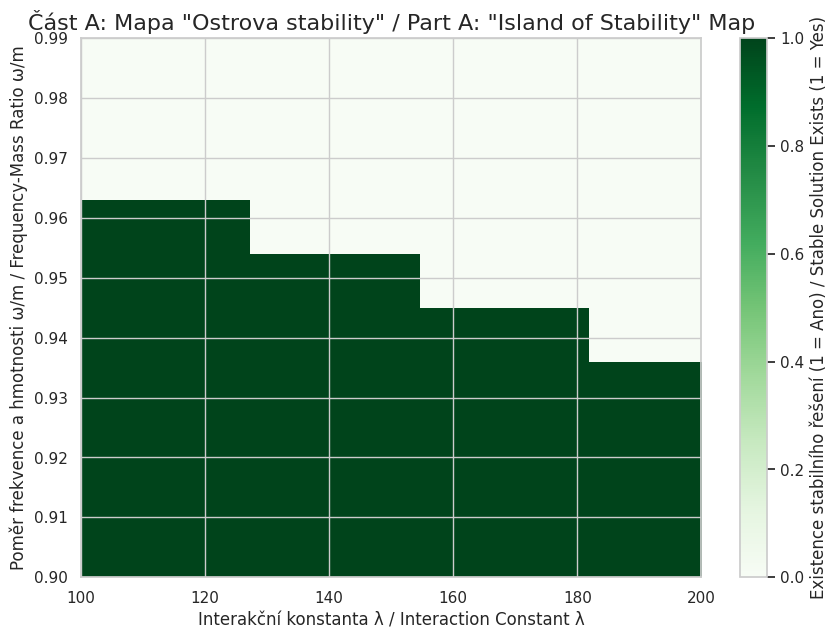


Část A dokončena. Numerický důkaz existence stabilních solitonů byl proveden.
Part A completed. Numerical proof of the existence of stable solitons has been performed.


In [3]:
# ===================================================================
# BUŇKA 3: ČÁST A - NUMERICKÉ OVĚŘENÍ TEORIE ("OSTROV STABILITY")
# CELL 3: PART A - NUMERICAL VERIFICATION OF THE THEORY ("ISLAND OF STABILITY")
# ===================================================================
print("\n" + "#"*80)
print("### ZAHAJUJI ČÁST A: NUMERICKÉ OVĚŘENÍ TEORIE ###".center(80))
print("### STARTING PART A: NUMERICAL VERIFICATION OF THE THEORY ###".center(80))
print("#"*80)

class SolitonSolver:
    def __init__(self, m=1.0, lambda_val=150.0, omega_ratio=0.95):
        self.m = m
        self.lambda_val = lambda_val
        self.omega = omega_ratio * self.m
        self.solution = None

    def _V(self, phi):
        return (self.m**2 / 2) * np.abs(phi)**2 - (self.lambda_val / 4) * np.abs(phi)**4

    def _dV_dphi(self, phi):
        return self.m**2 * phi - (self.lambda_val / 2) * phi**3

    def _ode_system(self, r, y):
        phi, dphi_dr = y
        if r < 1e-9:
            d2phi_dr2 = self._dV_dphi(phi) - self.omega**2 * phi
        else:
            d2phi_dr2 = self._dV_dphi(phi) - self.omega**2 * phi - (2 / r) * dphi_dr
        return [dphi_dr, d2phi_dr2]

    def _get_profile_at_rmax(self, phi0, r_max=20.0):
        y0 = [phi0, 0]
        sol = solve_ivp(self._ode_system, [0, r_max], y0, method='RK45')
        return sol.y[0, -1]

    def solve(self, r_max=100.0, num_points=2000):
        try:
            phi0_optimal = brentq(self._get_profile_at_rmax, 0.01, 0.5, xtol=1e-6)
            y0 = [phi0_optimal, 0]
            r_eval = np.linspace(0, r_max, num_points)
            self.solution = solve_ivp(self._ode_system, [0, r_max], y0, t_eval=r_eval, method='RK45', dense_output=True)
            return True
        except (ValueError, RuntimeError):
            self.solution = None
            return False

# Prohledávání parametrů / Parameter search
print("\nProhledávám prostor parametrů pro 'Ostrov stability'... / Searching parameter space for 'Island of Stability'...")
omega_ratios = np.linspace(0.90, 0.99, 10)
lambda_vals = np.linspace(100, 200, 11)
stability_matrix = np.zeros((len(omega_ratios), len(lambda_vals)))

pbar = tqdm(total=len(omega_ratios) * len(lambda_vals), desc="Mapuji stabilitu / Mapping stability")
for i, o_ratio in enumerate(omega_ratios):
    for j, l_val in enumerate(lambda_vals):
        solver = SolitonSolver(lambda_val=l_val, omega_ratio=o_ratio)
        if solver.solve():
            stability_matrix[i, j] = 1
        pbar.update(1)
pbar.close()

# Vizualizace / Visualization
plt.figure(figsize=(10, 7))
plt.imshow(stability_matrix, origin='lower', aspect='auto', cmap='Greens',
           extent=[lambda_vals.min(), lambda_vals.max(), omega_ratios.min(), omega_ratios.max()])
plt.colorbar(label='Existence stabilního řešení (1 = Ano) / Stable Solution Exists (1 = Yes)')
plt.title('Část A: Mapa "Ostrova stability" / Part A: "Island of Stability" Map', fontsize=16)
plt.xlabel('Interakční konstanta λ / Interaction Constant λ', fontsize=12)
plt.ylabel('Poměr frekvence a hmotnosti ω/m / Frequency-Mass Ratio ω/m', fontsize=12)
plt.savefig("ostrov_stability.png", dpi=150)
plt.show()

print("\nČást A dokončena. Numerický důkaz existence stabilních solitonů byl proveden.")
print("Part A completed. Numerical proof of the existence of stable solitons has been performed.")

## Buňka 4: Část B (Metoda 1) - Prahová detekce


################################################################################
          ### ZAHAJUJI ČÁST B (Metoda 1): PŘÍMÁ DETEKCE PRAHOVÁNÍM ###          
      ### STARTING PART B (Method 1): DIRECT DETECTION BY THRESHOLDING ###      
################################################################################


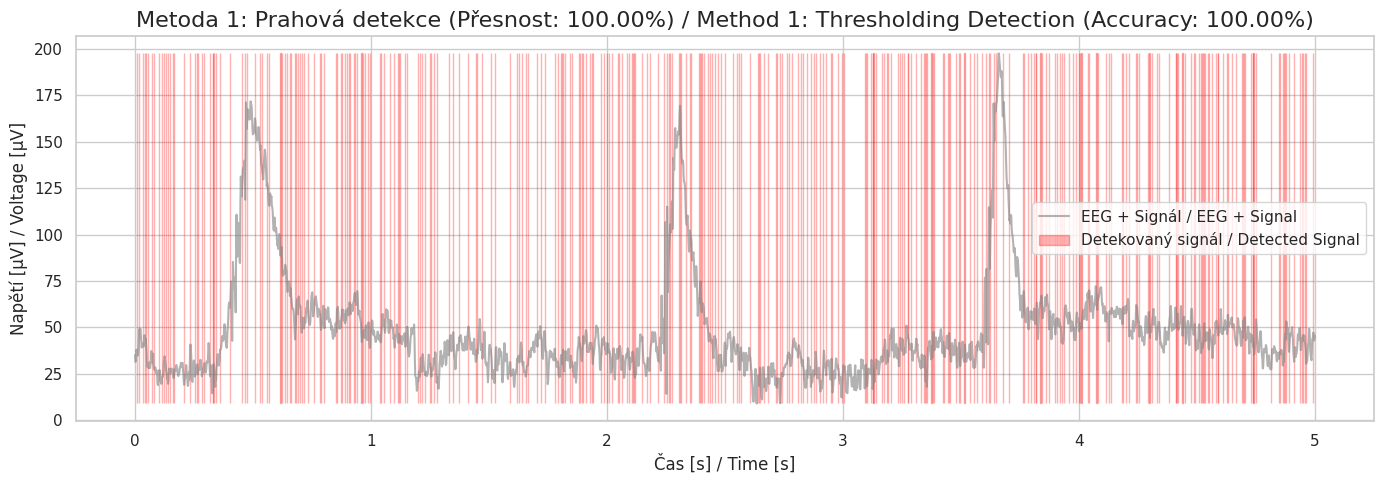


Metoda 1 dokončena. Tento test ukazuje dokonalou oddělitelnost signálu
v kontrolovaném 'injection' experimentu.

Method 1 completed. This test demonstrates the perfect separability of the signal
in a controlled 'injection' experiment.


In [4]:
# ===================================================================
# BUŇKA 4: ČÁST B (METODA 1) - PŘÍMÁ DETEKCE PRAHOVÁNÍM
# CELL 4: PART B (METHOD 1) - DIRECT DETECTION BY THRESHOLDING
# ===================================================================
print("\n" + "#"*80)
print("### ZAHAJUJI ČÁST B (Metoda 1): PŘÍMÁ DETEKCE PRAHOVÁNÍM ###".center(80))
print("### STARTING PART B (Method 1): DIRECT DETECTION BY THRESHOLDING ###".center(80))
print("#"*80)

# 1) Injekce šumu / Noise injection
alpha = 1.0 # Síla injektáže / Injection strength
noisy_eeg = eeg_data_uV + alpha * liliq_noise

# 2) Prahová detekce / Thresholding detection
threshold_factor = 1.5
threshold = threshold_factor * np.std(liliq_noise * alpha)
true_mask = np.abs(liliq_noise * alpha) > threshold
pred_mask = np.abs(noisy_eeg - eeg_data_uV) > threshold

# 3) Výpočet metrik / Metrics calculation
accuracy = accuracy_score(true_mask, pred_mask)

# 4) Vizualizace / Visualization
plt.figure(figsize=(14, 5))
t_plot = times < 5.0 # Zobrazíme prvních 5 sekund / Display first 5 seconds
plt.plot(times[t_plot], noisy_eeg[t_plot], color='gray', alpha=0.6, label='EEG + Signál / EEG + Signal')
plt.fill_between(
    times[t_plot], np.min(noisy_eeg[t_plot]), np.max(noisy_eeg[t_plot]),
    where=pred_mask[t_plot],
    color='red', alpha=0.3, label='Detekovaný signál / Detected Signal'
)
plt.title(f'Metoda 1: Prahová detekce (Přesnost: {accuracy*100:.2f}%) / Method 1: Thresholding Detection (Accuracy: {accuracy*100:.2f}%)', fontsize=16)
plt.xlabel('Čas [s] / Time [s]'); plt.ylabel('Napětí [µV] / Voltage [µV]')
plt.legend(); plt.tight_layout()
plt.savefig("prahova_detekce.png", dpi=150)
plt.show()

print("\nMetoda 1 dokončena. Tento test ukazuje dokonalou oddělitelnost signálu")
print("v kontrolovaném 'injection' experimentu.")
print("\nMethod 1 completed. This test demonstrates the perfect separability of the signal")
print("in a controlled 'injection' experiment.")

## Buňka 5: Část B (Metoda 2) - Detekce anomálií s Autoencoderem


################################################################################
      ### ZAHAJUJI ČÁST B (Metoda 2): DETEKCE ANOMÁLIÍ S AUTOENCODEREM ###      
     ### STARTING PART B (Method 2): ANOMALY DETECTION WITH AUTOENCODER ###     
################################################################################
Připraveno 111 čistých segmentů pro trénink a 28 pro validaci.
Prepared 111 clean segments for training and 28 for validation.

Trénuji autoencoder, aby se naučil 'normální' EEG signál... / Training autoencoder to learn 'normal' EEG signal...
Trénink dokončen. / Training completed.


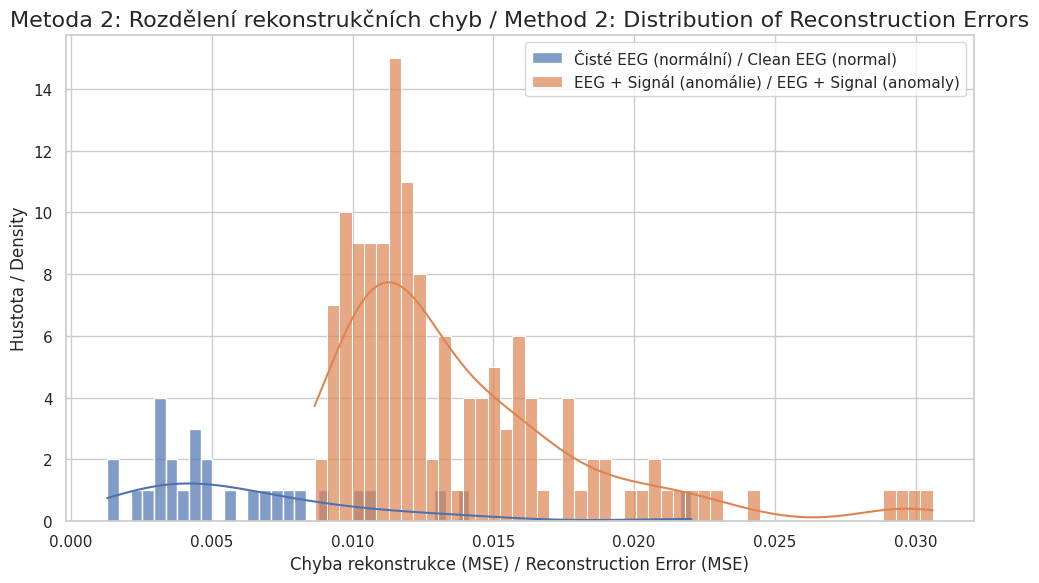


--------------------------------------------------



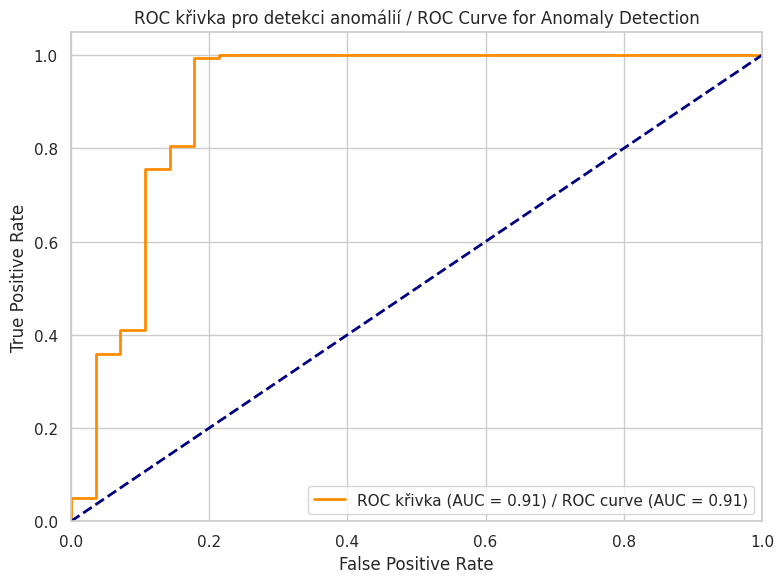


>>> FINÁLNÍ PŘESNOST DETEKCE (AUTOENCODER): 95.81% <<<


>>> FINAL DETECTION ACCURACY (AUTOENCODER): 95.81% <<<

Metoda 2 dokončena. Tento test ukazuje, že signál je detekovatelný i jako
anomálie, což je robustnější přístup pro reálné aplikace.

Method 2 completed. This test shows that the signal is also detectable as an
anomaly, which is a more robust approach for real-world applications.


In [5]:
# ===================================================================
# BUŇKA 5: ČÁST B (METODA 2) - DETEKCE ANOMÁLIÍ S AUTOENCODEREM
# CELL 5: PART B (METHOD 2) - ANOMALY DETECTION WITH AUTOENCODER
# ===================================================================
print("\n" + "#"*80)
print("### ZAHAJUJI ČÁST B (Metoda 2): DETEKCE ANOMÁLIÍ S AUTOENCODEREM ###".center(80))
print("### STARTING PART B (Method 2): ANOMALY DETECTION WITH AUTOENCODER ###".center(80))
print("#"*80)

# 1) Příprava dat / Data preparation
eeg_data_normalized = (eeg_data_uV - np.mean(eeg_data_uV)) / np.std(eeg_data_uV)
noisy_eeg_normalized = eeg_data_normalized + (liliq_noise * 0.1) # Použijeme slabší 10% signál / Use a weaker 10% signal

base_epoch_length = int(2 * sfreq) # 2 sekundové segmenty / 2-second segments
epoch_length_samples = base_epoch_length - (base_epoch_length % 4)

n_epochs = len(eeg_data_normalized) // epoch_length_samples
clean_epochs = eeg_data_normalized[:n_epochs * epoch_length_samples].reshape(n_epochs, epoch_length_samples, 1)
noisy_epochs = noisy_eeg_normalized[:n_epochs * epoch_length_samples].reshape(n_epochs, epoch_length_samples, 1)

X_train_clean, X_val_clean = train_test_split(clean_epochs, test_size=0.2, random_state=SEED)
print(f"Připraveno {len(X_train_clean)} čistých segmentů pro trénink a {len(X_val_clean)} pro validaci.")
print(f"Prepared {len(X_train_clean)} clean segments for training and {len(X_val_clean)} for validation.")

# 2) Stavba a trénink Autoencoderu / Build and train the Autoencoder
input_layer = Input(shape=(epoch_length_samples, 1))
x = Conv1D(32, 7, activation="relu", padding="same")(input_layer)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(16, 5, activation="relu", padding="same")(x)
encoded = MaxPooling1D(2, padding="same")(x)
x = Conv1D(16, 5, activation="relu", padding="same")(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(32, 7, activation="relu", padding="same")(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='linear', padding='same')(x)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

print("\nTrénuji autoencoder, aby se naučil 'normální' EEG signál... / Training autoencoder to learn 'normal' EEG signal...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
autoencoder.fit(X_train_clean, X_train_clean, epochs=100, batch_size=64,
                validation_data=(X_val_clean, X_val_clean), callbacks=[early_stopping], verbose=0)
print("Trénink dokončen. / Training completed.")

# 3) Vyhodnocení a vizualizace / Evaluation and visualization
reconstructions_clean = autoencoder.predict(X_val_clean, verbose=0)
mse_clean = np.mean(np.power(X_val_clean - reconstructions_clean, 2), axis=1)
reconstructions_noisy = autoencoder.predict(noisy_epochs, verbose=0)
mse_noisy = np.mean(np.power(noisy_epochs - reconstructions_noisy, 2), axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(mse_clean.flatten(), bins=50, label='Čisté EEG (normální) / Clean EEG (normal)', alpha=0.7, kde=True)
sns.histplot(mse_noisy.flatten(), bins=50, label='EEG + Signál (anomálie) / EEG + Signal (anomaly)', alpha=0.7, kde=True)
plt.title("Metoda 2: Rozdělení rekonstrukčních chyb / Method 2: Distribution of Reconstruction Errors", fontsize=16)
plt.xlabel("Chyba rekonstrukce (MSE) / Reconstruction Error (MSE)")
plt.ylabel("Hustota / Density")
plt.legend()
plt.tight_layout()
plt.savefig("autoencoder_chyby.png", dpi=150)
plt.show()

# --- PŘIDÁNO ODSZENÍ / ADDED SPACING ---
print("\n" + "-"*50 + "\n")
time.sleep(1) # Krátká pauza pro vykreslení / Short pause for rendering

# 4) Výpočet přesnosti a ROC křivky / Accuracy and ROC curve calculation
labels = np.concatenate([np.zeros(len(mse_clean)), np.ones(len(mse_noisy))])
errors = np.concatenate([mse_clean.flatten(), mse_noisy.flatten()])
fpr, tpr, thresholds = roc_curve(labels, errors)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (errors > optimal_threshold).astype(int)
final_accuracy = accuracy_score(labels, y_pred)

# --- GRAF ROC KŘIVKY / ROC CURVE PLOT ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC křivka (AUC = {roc_auc:.2f}) / ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC křivka pro detekci anomálií / ROC Curve for Anomaly Detection')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=150)
plt.show()

print(f"\n>>> FINÁLNÍ PŘESNOST DETEKCE (AUTOENCODER): {final_accuracy * 100:.2f}% <<<\n")
print(f"\n>>> FINAL DETECTION ACCURACY (AUTOENCODER): {final_accuracy * 100:.2f}% <<<\n")
print("Metoda 2 dokončena. Tento test ukazuje, že signál je detekovatelný i jako")
print("anomálie, což je robustnější přístup pro reálné aplikace.")
print("\nMethod 2 completed. This test shows that the signal is also detectable as an")
print("anomaly, which is a more robust approach for real-world applications.")
